# Data Augmentation

In [1]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Model, optimizers

In [3]:
# READ IN AUDIO FILES 
audio = "C:\\Users\\bhuva\\Downloads\\RAVDESS\\audio_speech_actors_01-24\\"

In [4]:
# READ IN CSV FILE FROM EDA_PREPROCESSING
audio_df=pd.read_csv('Uploads/audio.csv',usecols=['emotion','path','gender','actor'])
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,C:\Users\bhuva\Downloads\RAVDESS\audio_speech_...
1,male,neutral,1,C:\Users\bhuva\Downloads\RAVDESS\audio_speech_...
2,male,neutral,1,C:\Users\bhuva\Downloads\RAVDESS\audio_speech_...
3,male,neutral,1,C:\Users\bhuva\Downloads\RAVDESS\audio_speech_...
4,male,calm,1,C:\Users\bhuva\Downloads\RAVDESS\audio_speech_...


In [5]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(audio_df, test_size=0.2, random_state=0,
                               stratify=audio_df[['emotion','gender','actor']])

In [6]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

(1152, 1)


## Add Noise, Stretch, Speed and Pitch to Original Audio File

In [12]:
# PLAY AUDIO FILE
#librosa.output.write_wav('Uploads/ipd.Audio Files/MaleSadOriginal.wav', x, sr)
import soundfile as sf
sf.write('Uploads/ipd.Audio Files/MaleSadOriginal.wav', x, sr, 'PCM_24')
Audio(data=x, rate=sr)


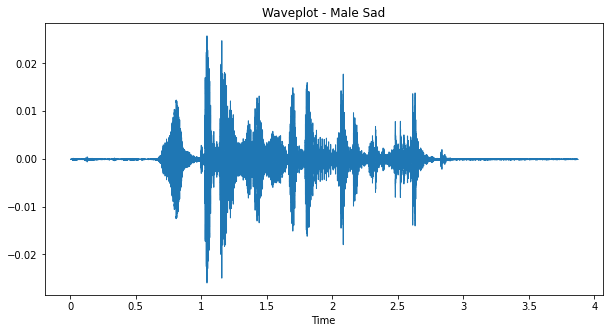

In [13]:
# MALE SAD ORIGINAL AUDIO FILE
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
x, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Sad')
plt.savefig('Waveplot_MaleSad.png')


In [14]:
# FUNCTION TO ADD WHITE NOISE
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

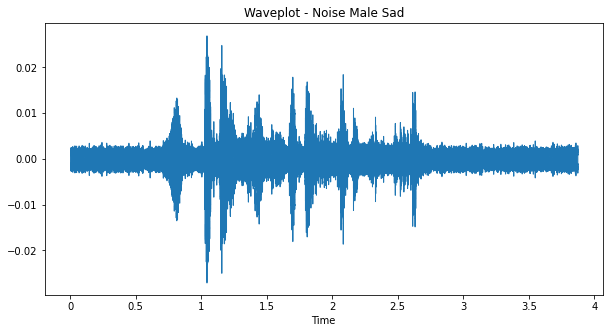

In [16]:
# ADD NOISE TO MALE SAD ORIGINAL AUDIO FILE
x = noise(x)
plt.figure(figsize=(10, 5))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Noise Male Sad')
plt.savefig('Waveplot_MaleSadNoise.png')


In [18]:
# PLAY AUDIO FILE
#librosa.output.write_wav('Uploads/ipd.Audio Files/MaleSadNoise.wav', x, sr)
import soundfile as sf
sf.write('Uploads/ipd.Audio Files/MaleSadNoise.wav', x, sr, 'PCM_24')
Audio(data=x, rate=sr)

In [19]:
# FUNCTION TO STRETCH THE SOUND
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

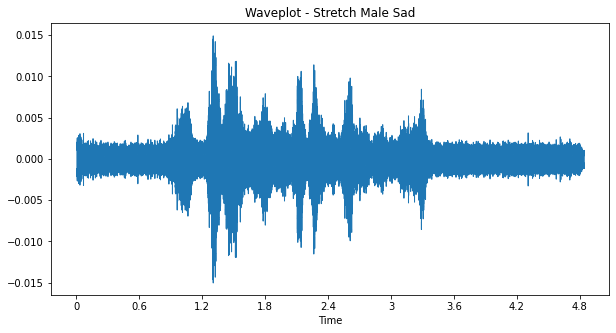

In [20]:
# ADD STRETCH TO MALE SAD ORIGINAL AUDIO FILE
x = stretch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSadStretch.png')

In [21]:
# PLAY AUDIO FILE
#librosa.output.write_wav('Uploads/ipd.Audio Files/MaleSadStretch.wav', x, sr)
import soundfile as sf
sf.write('Uploads/ipd.Audio Files/MaleSadStretch.wav', x, sr, 'PCM_24')
Audio(data=x, rate=sr)

In [22]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

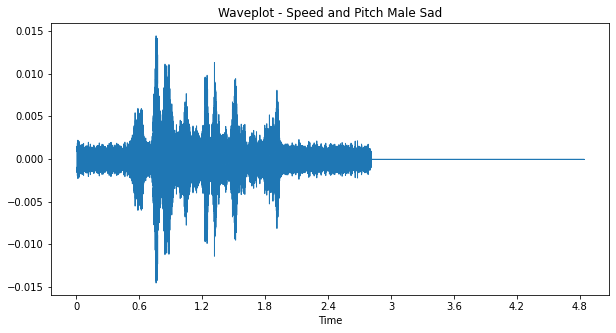

In [23]:
# ADD SPEED AND PITCH TO MALE SAD ORIGINAL AUDIO FILE
x = speedNpitch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Speed and Pitch Male Sad')
plt.savefig('Waveplot_MaleSadSpeedPitch.png')

In [24]:
# PLAY AUDIO FILE
#librosa.output.write_wav('Uploads/ipd.Audio Files/MaleSadSpeedPitch.wav', x, sr)
import soundfile as sf
sf.write('Uploads/ipd.Audio Files/MaleSadSpeedPitch.wav', x, sr, 'PCM_24')
Audio(data=x, rate=sr)

## Apply Data Augmentation Methods to Train Set

In [25]:
# FEATURE EXTRACTION ON RAW AUDIO FILES
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1152


,log_spec
0,"[-52.010105, -52.010105, -52.010105, -52.01010..."
1,"[-67.544464, -67.4258, -67.53555, -67.255875, ..."
2,"[-68.685844, -68.489426, -68.54073, -68.602585..."
3,"[-46.855713, -43.8705, -44.344135, -45.735912,..."
4,"[-60.71909, -60.731354, -60.6048, -60.55546, -..."


In [26]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()

1152


,feature
0,"[-52.010105, -52.010105, -52.010105, -52.01010..."
1,"[-67.544464, -67.4258, -67.53555, -67.255875, ..."
2,"[-68.685844, -68.489426, -68.54073, -68.602585..."
3,"[-46.855713, -43.8705, -44.344135, -45.735912,..."
4,"[-60.71909, -60.731354, -60.6048, -60.55546, -..."


In [27]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()


1152


,feature
0,"[-54.402718, -54.402718, -54.402718, -54.40271..."
1,"[-68.90462, -68.79708, -68.51444, -68.475105, ..."
2,"[-68.96996, -68.86758, -69.01645, -69.15323, -..."
3,"[-48.97706, -46.493237, -47.943726, -47.772415..."
4,"[-60.881638, -60.73136, -60.66008, -60.81869, ..."


In [28]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()


1152


,feature
0,"[-52.010105, -52.010105, -52.010105, -52.01010..."
1,"[-67.544464, -67.4258, -67.53555, -67.255875, ..."
2,"[-68.685844, -68.489426, -68.54073, -68.602585..."
3,"[-46.855713, -43.8705, -44.344135, -45.735912,..."
4,"[-60.71909, -60.731354, -60.6048, -60.55546, -..."


## Combine Tables For Modeling

In [29]:
# EXTRACT EMOTION LABELS FROM TRAIN
labels = train.emotion
labels.reset_index(drop=True, inplace=True)
labels

0          angry
1       surprise
2       surprise
3       surprise
4       surprise
          ...   
1147       angry
1148         sad
1149         sad
1150        calm
1151        fear
Name: emotion, Length: 1152, dtype: object

In [30]:
# ADD CORRESPONDING EMOTION LABELS TO DF['LOG_SPEC']
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
mfcc = pd.concat([mfcc_df,labels], axis=1,ignore_index=True)
mfcc = mfcc.rename(index=str, columns={259: "emotion"})

In [31]:
# ADD CORRESPONDING EMOTION LABELS TO DF_NOISE['FEATURE']
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={259: "label"})

In [32]:
# ADD CORRESPONDING EMOTION LABELS TO DF_SPEEDPITCH['FEATURE']
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={259: "label"})

In [33]:
# ADD CORRESPONDING EMOTION LABELS TO DF_STRETCH['FEATURE']
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={259: "label"})

In [34]:
# JOIN FOUR DATA FRAMES FOR MODELING
combined_df = pd.concat([mfcc, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
4603,-55.738033,-54.639275,-54.561520,-55.446495,-55.953838,-56.111977,-56.143452,-56.143452,-56.093372,-56.071312,...,-55.757679,-55.860535,-55.976215,-55.939507,-56.025585,-55.985035,-56.052589,-56.140293,-56.143452,angry
4604,-61.335144,-64.469688,-68.031677,-67.961922,-67.886108,-68.045006,-68.102654,-68.009727,-67.908470,-67.852524,...,-67.772095,-67.719231,-67.535286,-67.411583,-67.643387,-67.714966,-67.877182,-67.261528,-64.486992,sad
4605,-76.470039,-76.470039,-76.470039,-76.470039,-76.470039,-76.051994,-76.398041,-76.470039,-76.470039,-76.470039,...,-76.464539,-76.470039,-76.470039,-76.470039,-76.470039,-76.470039,-76.470039,-76.470039,-76.470039,sad
4606,-83.791634,-79.657211,-77.127083,-76.456398,-77.006729,-76.750923,-76.038673,-75.667969,-75.560966,-76.109825,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calm
4607,-70.622658,-70.637054,-70.727631,-70.727631,-70.727631,-70.671234,-70.727631,-70.727631,-70.727631,-70.727631,...,-67.050056,-67.557304,-59.468182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,fear


In [35]:
mfcc.shape

(1152, 260)

In [36]:
noise.shape

(1152, 260)

In [37]:
speedpitch.shape

(1152, 260)

In [38]:
stretch.shape

(1152, 260)

In [39]:
X_train = combined_df.iloc[:, :-1]
y_train = combined_df.iloc[:, -1:]

## Feature Extraction for Test Set

In [40]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(test.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()

288


,mel_spectrogram
0,"[-52.763527, -52.763527, -52.763527, -52.76352..."
1,"[-61.244244, -58.15054, -56.49416, -55.623848,..."
2,"[-52.72294, -52.05953, -51.746418, -51.12377, ..."
3,"[-52.100067, -52.100067, -52.100067, -52.10006..."
4,"[-61.70223, -60.7178, -59.869873, -59.600273, ..."


In [41]:
test.reset_index(drop=True,inplace=True)

In [42]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([test,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined.head()

,gender,emotion,actor,path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,C:\Users\bhuva\Downloads\RAVDESS\audio_speech_...,-52.763527,-52.763527,-52.763527,-52.763527,-52.763527,-52.763527,...,-44.213242,-44.874420,-44.892040,-45.049088,-45.913139,-46.570522,-47.174435,-47.971081,-48.450653,-50.120926
1,male,calm,21,C:\Users\bhuva\Downloads\RAVDESS\audio_speech_...,-61.244244,-58.150539,-56.494160,-55.623848,-54.973141,-54.715199,...,-66.325974,-66.646637,-66.721497,-67.368507,-67.622414,-68.268074,-68.894150,-70.283775,-70.105820,-70.397163
2,female,happy,16,C:\Users\bhuva\Downloads\RAVDESS\audio_speech_...,-52.722939,-52.059528,-51.746418,-51.123772,-50.795643,-50.652779,...,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773
3,female,angry,12,C:\Users\bhuva\Downloads\RAVDESS\audio_speech_...,-52.100067,-52.100067,-52.100067,-52.100067,-52.100067,-52.100067,...,-51.312180,-51.426289,-51.391212,-51.352631,-51.349060,-51.352383,-51.363037,-51.370930,-49.604958,-43.104076
4,male,fear,23,C:\Users\bhuva\Downloads\RAVDESS\audio_speech_...,-61.702229,-60.717800,-59.869873,-59.600273,-59.231483,-59.133255,...,-61.860188,-60.662636,-60.089775,-60.016575,-60.275181,-59.831600,-59.677677,-59.809269,-59.261845,-58.241127


In [43]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [44]:
# CHECK TOP 5 ROWS
print(df_combined.shape)
df_combined.head()

(288, 262)


,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,-52.763527,-52.763527,-52.763527,-52.763527,-52.763527,-52.763527,-52.763527,...,-44.213242,-44.874420,-44.892040,-45.049088,-45.913139,-46.570522,-47.174435,-47.971081,-48.450653,-50.120926
1,male,calm,21,-61.244244,-58.150539,-56.494160,-55.623848,-54.973141,-54.715199,-53.624706,...,-66.325974,-66.646637,-66.721497,-67.368507,-67.622414,-68.268074,-68.894150,-70.283775,-70.105820,-70.397163
2,female,happy,16,-52.722939,-52.059528,-51.746418,-51.123772,-50.795643,-50.652779,-50.606140,...,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773,-53.232773
3,female,angry,12,-52.100067,-52.100067,-52.100067,-52.100067,-52.100067,-52.100067,-52.100067,...,-51.312180,-51.426289,-51.391212,-51.352631,-51.349060,-51.352383,-51.363037,-51.370930,-49.604958,-43.104076
4,male,fear,23,-61.702229,-60.717800,-59.869873,-59.600273,-59.231483,-59.133255,-58.666618,...,-61.860188,-60.662636,-60.089775,-60.016575,-60.275181,-59.831600,-59.677677,-59.809269,-59.261845,-58.241127


In [45]:
# SEPARATE DF_COMBINED INTO X_TEST AND Y_TEST
X_test = df_combined.iloc[:, 3:]
y_test = df_combined.iloc[:,:2].drop(columns=['gender'])

## Data Preprocessing

In [46]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


In [47]:
# TURN INTO ARRAYS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [48]:
y_train

array([['angry'],
       ['surprise'],
       ['surprise'],
       ...,
       ['sad'],
       ['calm'],
       ['fear']], dtype=object)

In [49]:
# ONE HOT ENCODE EMOTION LABELS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [50]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [51]:
# RESHAPE TO ADD 3D TENSOR FOR 1D CNN INPUT
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_test.shape

(288, 259, 1)

In [52]:
X_train.shape[0]

4608

# CNN

In [53]:
# BUILD 1D CNN LAYERS
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=(20),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 240, 64)           1344      
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 128)          163968    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 27, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 128)            327808    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                    

In [54]:
checkpoint = ModelCheckpoint('face_detector.h15', monitor= 'val_loss', mode= 'min', save_best_only = True, verbose= 1)

# FIT MODEL
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=8, epochs=20, validation_data=(X_test, y_test),callbacks=checkpoint)


Epoch 1/20
576/576 [==============================] - ETA: 0s - loss: 2.2760 - accuracy: 0.2795
Epoch 1: val_loss improved from inf to 1.94248, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 20s 33ms/step - loss: 2.2760 - accuracy: 0.2795 - val_loss: 1.9425 - val_accuracy: 0.3438
Epoch 2/20
576/576 [==============================] - ETA: 0s - loss: 1.8637 - accuracy: 0.3355
Epoch 2: val_loss improved from 1.94248 to 1.73832, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 18s 32ms/step - loss: 1.8637 - accuracy: 0.3355 - val_loss: 1.7383 - val_accuracy: 0.4028
Epoch 3/20
576/576 [==============================] - ETA: 0s - loss: 1.7042 - accuracy: 0.3728
Epoch 3: val_loss improved from 1.73832 to 1.63653, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 19s 33ms/step - loss: 1.7042 - accuracy: 0.3728 - val_loss: 1.6365 - val_accuracy: 0.3924
Epoch 4/20
576/576 [==============================] - ETA: 0s - loss: 1.6202 - accuracy: 0.3987
Epoch 4: val_loss improved from 1.63653 to 1.56920, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 19s 32ms/step - loss: 1.6202 - accuracy: 0.3987 - val_loss: 1.5692 - val_accuracy: 0.4097
Epoch 5/20
576/576 [==============================] - ETA: 0s - loss: 1.5431 - accuracy: 0.4115
Epoch 5: val_loss improved from 1.56920 to 1.51346, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 18s 32ms/step - loss: 1.5431 - accuracy: 0.4115 - val_loss: 1.5135 - val_accuracy: 0.4479
Epoch 6/20
576/576 [==============================] - ETA: 0s - loss: 1.4739 - accuracy: 0.4531
Epoch 6: val_loss improved from 1.51346 to 1.46412, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 18s 32ms/step - loss: 1.4739 - accuracy: 0.4531 - val_loss: 1.4641 - val_accuracy: 0.4479
Epoch 7/20
575/576 [============================>.] - ETA: 0s - loss: 1.4030 - accuracy: 0.4833
Epoch 7: val_loss improved from 1.46412 to 1.41002, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 18s 32ms/step - loss: 1.4031 - accuracy: 0.4833 - val_loss: 1.4100 - val_accuracy: 0.4826
Epoch 8/20
576/576 [==============================] - ETA: 0s - loss: 1.3437 - accuracy: 0.5024
Epoch 8: val_loss improved from 1.41002 to 1.39144, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 19s 32ms/step - loss: 1.3437 - accuracy: 0.5024 - val_loss: 1.3914 - val_accuracy: 0.4931
Epoch 9/20
576/576 [==============================] - ETA: 0s - loss: 1.2961 - accuracy: 0.5206
Epoch 9: val_loss improved from 1.39144 to 1.37923, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 18s 31ms/step - loss: 1.2961 - accuracy: 0.5206 - val_loss: 1.3792 - val_accuracy: 0.5139
Epoch 10/20
574/576 [============================>.] - ETA: 0s - loss: 1.2270 - accuracy: 0.5483
Epoch 10: val_loss did not improve from 1.37923
576/576 [==============================] - 16s 28ms/step - loss: 1.2284 - accuracy: 0.5486 - val_loss: 1.3861 - val_accuracy: 0.5069
Epoch 11/20
575/576 [============================>.] - ETA: 0s - loss: 1.1843 - accuracy: 0.5691
Epoch 11: val_loss did not improve from 1.37923
576/576 [==============================] - 16s 28ms/step - loss: 1.1840 - accuracy: 0.5692 - val_loss: 1.3874 - val_accuracy: 0.5174
Epoch 12/20
576/576 [==============================] - ETA: 0s - loss: 1.1196 - accuracy: 0.6044
Epoch 12: val_loss improved from 1.37923 to 1.33633, saving model to face_detector.h15


INFO:tensorflow:Assets written to: face_detector.h15\assets


INFO:tensorflow:Assets written to: face_detector.h15\assets


576/576 [==============================] - 18s 32ms/step - loss: 1.1196 - accuracy: 0.6044 - val_loss: 1.3363 - val_accuracy: 0.5312
Epoch 13/20
575/576 [============================>.] - ETA: 0s - loss: 1.0815 - accuracy: 0.6250
Epoch 13: val_loss did not improve from 1.33633
576/576 [==============================] - 16s 28ms/step - loss: 1.0815 - accuracy: 0.6248 - val_loss: 1.3916 - val_accuracy: 0.5278
Epoch 14/20
575/576 [============================>.] - ETA: 0s - loss: 1.0250 - accuracy: 0.6376
Epoch 14: val_loss did not improve from 1.33633
576/576 [==============================] - 16s 28ms/step - loss: 1.0253 - accuracy: 0.6374 - val_loss: 1.4130 - val_accuracy: 0.5243
Epoch 15/20
576/576 [==============================] - ETA: 0s - loss: 0.9750 - accuracy: 0.6610
Epoch 15: val_loss did not improve from 1.33633
576/576 [==============================] - 16s 28ms/step - loss: 0.9750 - accuracy: 0.6610 - val_loss: 1.3803 - val_accuracy: 0.5417
Epoch 16/20
576/576 [============

In [55]:
model.save_weights("best_model_weights.h5")
model.save('best_model.h5')
print("Saved model to disk")

Saved model to disk


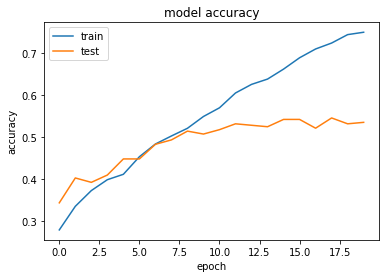

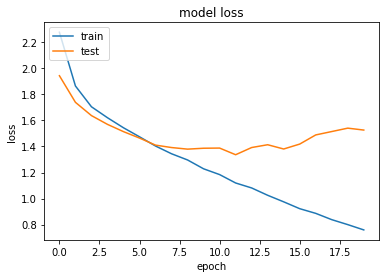

In [56]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [57]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = actual.join(predictions)
finaldf[140:150]

9/9 [==============================] - 0s 27ms/step


,Actual Values,Predicted Values
140,sad,sad
141,surprise,angry
142,neutral,fear
143,sad,sad
144,fear,surprise
145,sad,fear
146,disgust,disgust
147,angry,angry
148,surprise,happy
149,angry,surprise


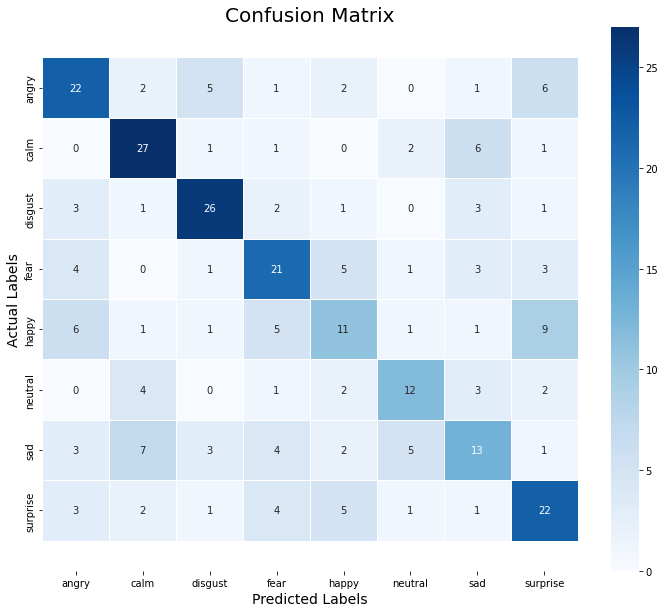

In [58]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [59]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.54      0.56      0.55        39
        calm       0.61      0.71      0.66        38
     disgust       0.68      0.70      0.69        37
        fear       0.54      0.55      0.55        38
       happy       0.39      0.31      0.35        35
     neutral       0.55      0.50      0.52        24
         sad       0.42      0.34      0.38        38
    surprise       0.49      0.56      0.52        39

    accuracy                           0.53       288
   macro avg       0.53      0.53      0.53       288
weighted avg       0.53      0.53      0.53       288



## Hyperparameter Tuning

In [61]:
# STRATIFIED SHUFFLE SPLIT
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
SSS = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in SSS.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [62]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [63]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [64]:
# RESHAPE DATA TO 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [65]:
# CREATE FUNCTION FOR KERAS CLASSIFIER
def make_classifier(optimizer='adam'):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.summary()
    opt = keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [66]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
model = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 32, 34],
    'nb_epoch': [50, 75, 100],
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=model,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 250, 64)           704       
                                                                 
 conv1d_4 (Conv1D)           (None, 241, 128)          82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 30, 128)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 128)           163968    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 128)           0         
 1D)                                                  

Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 20ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 250, 64)           704       
                                                                 
 conv1d_16 (Conv1D)          (None, 241, 128)          82048     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 30, 128)           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 21, 128)           16396

 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 18ms/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 250, 64)           704       
                                                                 
 conv1d_28 (Conv1D)          (None, 241, 128)          82048     
                                                            

 g1D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 2, 128)            0         
                                                                 
 flatten_12 (Flatten)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 dropout_38 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 19ms/step
Model: "sequenti

                                                                 
 dropout_48 (Dropout)        (None, 30, 128)           0         
                                                                 
 conv1d_50 (Conv1D)          (None, 21, 128)           163968    
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 2, 128)           0         
 g1D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 2, 128)            0         
                                                                 
 flatten_16 (Flatten)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 dropout_50 (Dropout)        (None, 256)               0         
          

 conv1d_60 (Conv1D)          (None, 250, 64)           704       
                                                                 
 conv1d_61 (Conv1D)          (None, 241, 128)          82048     
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 30, 128)           0         
                                                                 
 conv1d_62 (Conv1D)          (None, 21, 128)           163968    
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 2, 128)           0         
 g1D)                                                            
                                                                 
 dropout_61 (Dropout)        (None, 2, 128)            0         
          

24/24 [==============================] - 1s 20ms/step
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 250, 64)           704       
                                                                 
 conv1d_73 (Conv1D)          (None, 241, 128)          82048     
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 30, 128)           0         
                                                                 
 conv1d_74 (Conv1D)          (None, 21, 128)           163968    
                                                                 
 max_pooling1d_49 (MaxPoolin  (None, 2, 128)           0         

                                                                 
 dense_55 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 19ms/step
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_84 (Conv1D)          (None, 250, 64)           704       
                                                                 
 conv1d_85 (Conv1D)          (None, 241, 128)          82048     
                                                                 
 max_pooling1d_56 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                           

                                                                 
 flatten_31 (Flatten)        (None, 256)               0         
                                                                 
 dense_62 (Dense)            (None, 256)               65792     
                                                                 
 dropout_95 (Dropout)        (None, 256)               0         
                                                                 
 dense_63 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 20ms/step
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_96 (Conv1D)          (None, 250, 64)           704 

 conv1d_107 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_71 (MaxPoolin  (None, 2, 128)           0         
 g1D)                                                            
                                                                 
 dropout_106 (Dropout)       (None, 2, 128)            0         
                                                                 
 flatten_35 (Flatten)        (None, 256)               0         
                                                                 
 dense_70 (Dense)            (None, 256)               65792     
                                                                 
 dropout_107 (Dropout)       (None, 256)               0         
                                                                 
 dense_71 (Dense)            (None, 8)                 2056      
                                                                 
Total para

                                                                 
 max_pooling1d_78 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_117 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_119 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_79 (MaxPoolin  (None, 2, 128)           0         
 g1D)                                                            
                                                                 
 dropout_118 (Dropout)       (None, 2, 128)            0         
                                                                 
 flatten_39 (Flatten)        (None, 256)               0         
                                                                 
 dense_78 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_129 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_130 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_86 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_129 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_131 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_87 (MaxPoolin  (None, 2, 128)           0         
 g1D)                                                            
          

Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 20ms/step
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_141 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_142 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_94 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_141 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_143 (Conv1D)         (None, 21, 128)           1639

 dense_100 (Dense)           (None, 256)               65792     
                                                                 
 dropout_152 (Dropout)       (None, 256)               0         
                                                                 
 dense_101 (Dense)           (None, 8)                 2056      
                                                                 
Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 19ms/step
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_153 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_154 (Conv1D)         (None, 241, 128)          82048     
                                                           

 ng1D)                                                           
                                                                 
 dropout_163 (Dropout)       (None, 2, 128)            0         
                                                                 
 flatten_54 (Flatten)        (None, 256)               0         
                                                                 
 dense_108 (Dense)           (None, 256)               65792     
                                                                 
 dropout_164 (Dropout)       (None, 256)               0         
                                                                 
 dense_109 (Dense)           (None, 8)                 2056      
                                                                 
Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 19ms/step
Model: "sequenti

                                                                 
 dropout_174 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_176 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_117 (MaxPooli  (None, 2, 128)           0         
 ng1D)                                                           
                                                                 
 dropout_175 (Dropout)       (None, 2, 128)            0         
                                                                 
 flatten_58 (Flatten)        (None, 256)               0         
                                                                 
 dense_116 (Dense)           (None, 256)               65792     
                                                                 
 dropout_176 (Dropout)       (None, 256)               0         
          

 conv1d_186 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_187 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_124 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_186 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_188 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_125 (MaxPooli  (None, 2, 128)           0         
 ng1D)                                                           
                                                                 
 dropout_187 (Dropout)       (None, 2, 128)            0         
          

24/24 [==============================] - 1s 19ms/step
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_198 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_199 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_132 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_198 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_200 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_133 (MaxPooli  (None, 2, 128)           0         

                                                                 
 dense_139 (Dense)           (None, 8)                 2056      
                                                                 
Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 19ms/step
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_210 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_211 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_140 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                           

                                                                 
 flatten_73 (Flatten)        (None, 256)               0         
                                                                 
 dense_146 (Dense)           (None, 256)               65792     
                                                                 
 dropout_221 (Dropout)       (None, 256)               0         
                                                                 
 dense_147 (Dense)           (None, 8)                 2056      
                                                                 
Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 18ms/step
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_222 (Conv1D)         (None, 250, 64)           704 

 conv1d_233 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_155 (MaxPooli  (None, 2, 128)           0         
 ng1D)                                                           
                                                                 
 dropout_232 (Dropout)       (None, 2, 128)            0         
                                                                 
 flatten_77 (Flatten)        (None, 256)               0         
                                                                 
 dense_154 (Dense)           (None, 256)               65792     
                                                                 
 dropout_233 (Dropout)       (None, 256)               0         
                                                                 
 dense_155 (Dense)           (None, 8)                 2056      
                                                                 
Total para

                                                                 
 max_pooling1d_162 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_243 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_245 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_163 (MaxPooli  (None, 2, 128)           0         
 ng1D)                                                           
                                                                 
 dropout_244 (Dropout)       (None, 2, 128)            0         
                                                                 
 flatten_81 (Flatten)        (None, 256)               0         
                                                                 
 dense_162

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_255 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_256 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_170 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_255 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_257 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_171 (MaxPooli  (None, 2, 128)           0         
 ng1D)                                                           
          

Total params: 314,568
Trainable params: 314,568
Non-trainable params: 0
_________________________________________________________________
24/24 [==============================] - 1s 19ms/step
Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_267 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_268 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_178 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_267 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_269 (Conv1D)         (None, 21, 128)           1639